In [20]:
#Utility Libs
import pandas as pd
import numpy as np
from IPython.display import Markdown as md
from scipy import stats


#Viz Libs
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

# Dataset

Let's load the dataset and perform some basic operations then,

1. Check the number of missing values in different columns
2. Fill those missing values with mean,median or mode and check the resulting distribution for any spread change
3. If there is a spread change, use MICE method for imputing instead of mean.

In [2]:
train = pd.read_csv("/home/lustbeast/Datasets/Train_Cleaned/train.csv")
test = pd.read_csv("/home/lustbeast/Datasets/Train_Cleaned/test.csv")

print(f"Train: {train.shape}  \nTest: {test.shape}")

print(f"Train Features: {train.columns} \nTest Features: {test.columns}")

Train: (33126, 8)  
Test: (10982, 5)
Train Features: Index(['image_name', 'patient_id', 'sex', 'age_approx',
       'anatom_site_general_challenge', 'diagnosis', 'benign_malignant',
       'target'],
      dtype='object') 
Test Features: Index(['image_name', 'patient_id', 'sex', 'age_approx',
       'anatom_site_general_challenge'],
      dtype='object')


<AxesSubplot:ylabel='Density'>

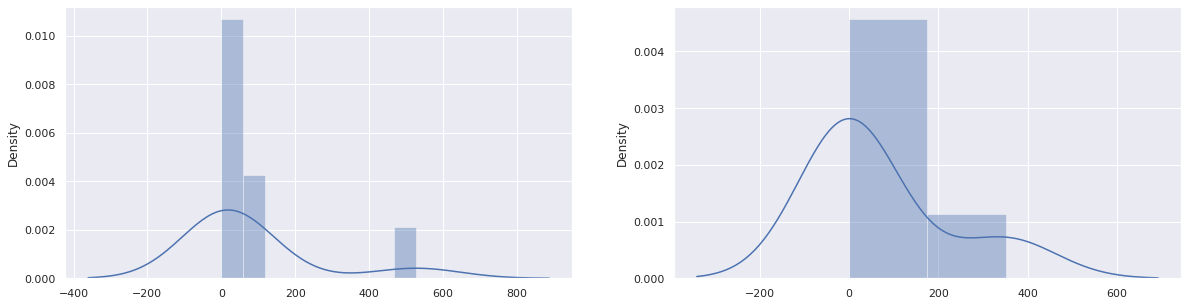

In [3]:
#missing values
train_miss = train.isna().sum()
test_miss = test.isna().sum()
fig,ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(train_miss,ax=ax[0])
sns.distplot(test_miss,ax=ax[1])

Distribution of NaN values in both train and test

<AxesSubplot:ylabel='Density'>

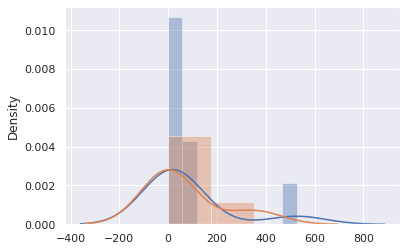

In [4]:
sns.distplot(train_miss)
sns.distplot(test_miss)

In [10]:
test_miss

image_name                         0
patient_id                         0
sex                                0
age_approx                         0
anatom_site_general_challenge    351
dtype: int64

| Train Miss Columns| Quantity |                 
| ----------------- | -------- |                 
| Sex |             | 65 |                       
| Age Approx |      | 68 |    
| Anatom Site General Challenge | |527|

These are the null values present in the train data
Let's summarize, 

1. The sex feature is a categorical variable -> needs to be imputed with mode
2. The age feature is integer variable -> can be imputed by mean or median
3. Anatom site is again a categorical -> mode 


The age and sex features has null values only among the benign class. But, If you check anatom feature, it has 518 null values among benign and 9 null values among malignant. So, have to impute those separately.

In [12]:
sex_null = train[train.sex.isnull()]
age_null = train[train.age_approx.isnull()]
anatom_null = train[train.anatom_site_general_challenge.isnull()]
print(sex_null.shape,age_null.shape,anatom_null.shape)

(65, 8) (68, 8) (527, 8)


In [14]:
anatom_null.target.value_counts()

0    518
1      9
Name: target, dtype: int64